In [1]:
import numpy as np
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
JSON_PATH = "/sise/home/tomerlao/datasets/APC-RTA/rta_input/tracks_info.json"
ALBUM_URIS_OF_EMBS_PATH = "/sise/home/tomerlao/datasets/APC-RTA/album_covers_embeddings/album_uris_{}.csv"
ALBUM_COVER_EMBS_PATH = "/sise/home/tomerlao/datasets/APC-RTA/album_covers_embeddings/{}_all_embs.npy"
album_cover_embs_algorithms = ['clip', 'dinov2']

In [ ]:
with open(JSON_PATH, 'r') as f:
    data = json.load(f)

# Dataset Statistics

In [19]:
album_uids = []
for track_id, track_info in tqdm(data.items()):
    album_uids.append(track_info['album_uri'].split(':')[-1])

unique_album_uids = set(album_uids)
print(f'Number of unique albums in MPD: {len(unique_album_uids)}')

100%|█████████████████████████████████████████████████████████████████████| 2262292/2262292 [00:16<00:00, 139027.47it/s]


Number of unique albums in MPD: 734684


In [20]:
num_of_embeddings = pd.read_csv(ALBUM_URIS_OF_EMBS_PATH.format('clip'), header=None).shape[0]

print(f'Number of unique album covers embeddings: {num_of_embeddings}')

Number of unique album covers embeddings: 733149


In [21]:
part = num_of_embeddings / len(unique_album_uids)
print(f'We have {part} of the data')

We have 0.9979106663545143 of the data


# Embeddings Scatter

In [4]:
artists_to_count = {}
artists_to_albums = {}

for track_id, track_info in tqdm(data.items()):
    artist = track_info['artist_name']
    if artist not in artists_to_count:
        artists_to_count[artist] = 0
        artists_to_albums[artist] = set()       
            
    artists_to_count[artist] += track_info['count']
    artists_to_albums[artist].add(track_info['album_uri'].split(':')[-1])

100%|█████████████████████████████████████████████████████████████████████| 2262292/2262292 [00:08<00:00, 255009.74it/s]


In [5]:
def get_k_most_popular_artists(artists_to_count, k):
    sorted_artists = sorted(artists_to_count.items(), key=lambda x: x[1], reverse=True)
    return sorted_artists[:k]

In [6]:
most_popular_artists = get_k_most_popular_artists(artists_to_count, 10)

most_popular_artists

[('Drake', 834123),
 ('Kanye West', 409292),
 ('Kendrick Lamar', 349691),
 ('Rihanna', 334552),
 ('The Weeknd', 311501),
 ('Eminem', 285014),
 ('Ed Sheeran', 268415),
 ('Future', 248576),
 ('J. Cole', 240072),
 ('Justin Bieber', 238619)]

In [16]:
def plot_scatter_for_algorithms(algorithm_name, most_popular_artists, artists_to_albums):
    album_uris = pd.read_csv(ALBUM_URIS_OF_EMBS_PATH.format(algorithm_name), header=None, names=['album_uri'])
    album_uri_to_album_emb_idx = {album_uri: idx for idx, album_uri in enumerate(album_uris['album_uri'].tolist())}
    
    album_covers_embs = np.load(ALBUM_COVER_EMBS_PATH.format(algorithm_name))
    print('loaded everything')
    
    # artist to album covers indices
    album_covers_indices_to_show = {}
    for artist, count in most_popular_artists:
        album_uris_of_artist = artists_to_albums[artist]
        album_covers_indices_to_show[artist] = []
        for album_uri in album_uris_of_artist:
            if album_uri in album_uri_to_album_emb_idx:
                album_covers_indices_to_show[artist].append(album_uri_to_album_emb_idx[album_uri])
    
    print('got indices')
    
    artist_to_album_covers_embs = {artist: album_covers_embs[indices] for artist, indices in album_covers_indices_to_show.items()}
    X = np.concatenate([artist_to_album_covers_embs[artist] for artist, _ in most_popular_artists])
    artist_of_emb = np.concatenate([[artist]*len(indices) for artist, indices in album_covers_indices_to_show.items()])
    print('got embs')
    
    tsne = TSNE(n_components=2, random_state=42)
    X_2d = tsne.fit_transform(X)
    print('fitted tsne')
    
    plt.figure(figsize=(6, 5))
    for artist in np.unique(artist_of_emb):
        tsned_embs_of_artist = X_2d[artist_of_emb == artist]
        plt.scatter(tsned_embs_of_artist[:, 0], tsned_embs_of_artist[:, 1], label=artist)
    
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    # place legend outside of plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.savefig(f'/sise/home/tomerlao/datasets/APC-RTA/album_covers_embeddings/{algorithm_name}_scatter.pdf', bbox_inches='tight')
    plt.show()
    

loaded everything
got indices
got embs
fitted tsne


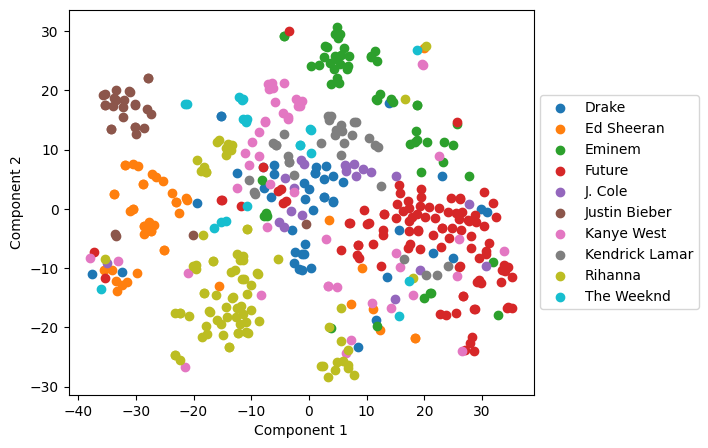

In [17]:
plot_scatter_for_algorithms('clip', most_popular_artists, artists_to_albums)

loaded everything
got indices
got embs
fitted tsne


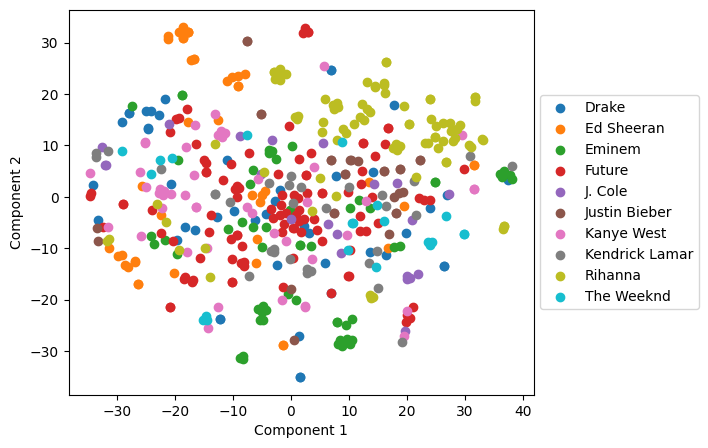

In [18]:
plot_scatter_for_algorithms('dinov2', most_popular_artists, artists_to_albums)